# Figure 7: Genetics analysis of fine-mapped variants from UKBB

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import utilities
from utilities import preprocessing, sequence, model_builder, classification_cleavage, motifs, relative_strength, genomic_context, genetics

import vcf


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
UKBBDIR = os.path.join(PROJECT, 'genetics', 'ukbb')
DATADIR = os.path.join(PROJECT, "manuscripts", "01_development", "data")
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_07", "ukbb")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

In [6]:
with open(os.path.join(RESDIR, "ukbb.representative_sites.pickle"), mode = 'rb') as handle:
    ukbb_repr = pickle.load(handle)

print(ukbb_repr.shape)
    
ukbb_repr = ukbb_repr.loc[ukbb_repr['referenceFeature'] == ukbb_repr['alternateFeature']].copy()
ukbb_repr_xte = ukbb_repr.loc[ukbb_repr['referenceFeature'].str.contains("terminal_exon")].copy()
ukbb_repr_int = ukbb_repr.loc[ukbb_repr['referenceFeature'].str.contains("intron")].copy()

print(ukbb_repr.shape)
print(ukbb_repr_xte.shape)
print(ukbb_repr_int.shape)


(63248, 45)
(63190, 45)
(17392, 45)
(44902, 45)


In [7]:
print("\n### Extended/terminal exonic:")
print(f"Number of variant-pA test sites             {ukbb_repr_xte.shape[0]:6}")
print(f"Number of unique variants                   {ukbb_repr_xte.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(ukbb_repr_xte.variantID.value_counts() > 1).sum():6}")

print("\n### Intronic:")
print(f"Number of variant-pA test sites             {ukbb_repr_int.shape[0]:6}")
print(f"Number of unique variants                   {ukbb_repr_int.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(ukbb_repr_int.variantID.value_counts() > 1).sum():6}")



### Extended/terminal exonic:
Number of variant-pA test sites              17392
Number of unique variants                    16539
Number of variants evaluated more than once    691

### Intronic:
Number of variant-pA test sites              44902
Number of unique variants                    44171
Number of variants evaluated more than once    547


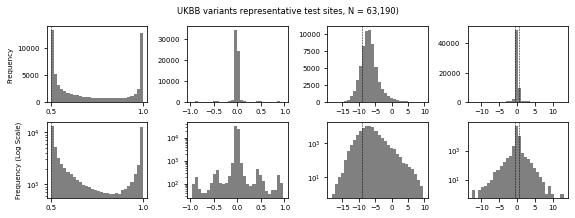

In [8]:
fig,ax = plt.subplots(2,4, figsize = (8,3))
ax = ax.T

for a in ax[0]:
    a.hist(ukbb_repr[['referenceClassprob','alternateClassprob']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = 0.5, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(0.5))

for a in ax[1]:
    a.hist(ukbb_repr['deltaClassification'], color = 'gray', bins = 30)
    a.xaxis.set_major_locator(MultipleLocator(0.5))

for a in ax[2]:
    a.hist(ukbb_repr[['referenceStrength','alternateStrength']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = -9, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))

for a in ax[3]:
    a.hist(ukbb_repr['deltaStrength'], color = 'gray', bins = 30)
    a.axvline(x = -0.5, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.axvline(x = +0.5, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))
    
for a in ax[:,1]:
    a.set_yscale('log')

ax[0][0].set_ylabel("Frequency")
ax[0][1].set_ylabel("Frequency (Log Scale)")

plt.suptitle(f"UKBB variants representative test sites, N = {len(ukbb_repr):,d})")
plt.tight_layout()
plt.show()


#### Filter representative test sites that have a significant effect on either PolyaID classification or PolyaStrength predictions

In [9]:
thresh_class = 0.5
thresh_strength = -9
thresh_delta = 1

condDIST     = (ukbb_repr['testSiteDistStranded'].between(-120,120))
condCLASS    = ((ukbb_repr['referenceClassprob'] >= thresh_class) | (ukbb_repr['alternateClassprob'] >= thresh_class))
condSTRENGTH = ((ukbb_repr['referenceStrength'] >= thresh_strength) | (ukbb_repr['alternateStrength'] >= thresh_strength))
condDELTA    = (np.abs(ukbb_repr['deltaStrength']) >= thresh_delta)

condXTE      = (ukbb_repr['referenceFeature'].str.contains('terminal_exon'))
condINT      = (ukbb_repr['referenceFeature'].str.contains('intron'))
condIC       = ((ukbb_repr['referenceFeature'] == 'intron:composite') & ((ukbb_repr['referenceICprob'] >= 0.8) | (ukbb_repr['alternateICprob'] >= 0.8)))
condIS       = ((ukbb_repr['referenceFeature'] == 'intron:skipped') & ((ukbb_repr['referenceISprob'] >= 0.8) | (ukbb_repr['alternateISprob'] >= 0.8)))
condFEATURE  = (condXTE | condIC | condIS)

condCOMB     = (condDIST & condCLASS & condSTRENGTH & condDELTA & condFEATURE)

print("Representative sites-\tCount =", len(ukbb_repr))

print("\nIndividual criteria:")
print(f"Within +/- 120 nt of variant  {condDIST.sum():6} ({condDIST.sum() / len(ukbb_repr):6.01%})")
print(f"PolyaID classification >= 0.5 {condCLASS.sum():6} ({condCLASS.sum() / len(ukbb_repr):6.01%})")
print(f"PolyaStrength score >= -9     {condSTRENGTH.sum():6} ({condSTRENGTH.sum() / len(ukbb_repr):6.01%})")
print(f"delta(PolyaStrength) >= 1     {condDELTA.sum():6} ({condDELTA.sum() / len(ukbb_repr):6.01%})")
print(f"In extended/terminal exon     {condXTE.sum():6} ({condXTE.sum() / len(ukbb_repr):6.01%})")
print(f"Intronic usage >= 0.8         {(condIC | condIS).sum():6} ({(condIC | condIS).sum() / len(ukbb_repr):6.01%})")

print(f"\nCombined criteria:            {condCOMB.sum():6} ({condCOMB.sum() / len(ukbb_repr):6.01%})")


Representative sites-	Count = 63190

Individual criteria:
Within +/- 120 nt of variant   63190 (100.0%)
PolyaID classification >= 0.5  63190 (100.0%)
PolyaStrength score >= -9      52086 ( 82.4%)
delta(PolyaStrength) >= 1       3339 (  5.3%)
In extended/terminal exon      17392 ( 27.5%)
Intronic usage >= 0.8            262 (  0.4%)

Combined criteria:              1228 (  1.9%)


In [10]:
ukbb_filt = ukbb_repr.loc[condCOMB].copy()
ukbb_filt_xte = ukbb_repr.loc[condCOMB & condXTE].copy()
ukbb_filt_int = ukbb_repr.loc[condCOMB & condINT].copy()

print(ukbb_repr.shape)
print(ukbb_filt.shape)
print(ukbb_filt_xte.shape)
print(ukbb_filt_int.shape)


(63190, 45)
(1228, 45)
(966, 45)
(262, 45)


In [11]:
# (ukbb_repr
#  .loc[condDIST & condCLASS & condSTRENGTH & condDELTA & condINT,['variantID','gene']]
#  .drop_duplicates()
#  .to_csv(os.path.join(RESDIR, 'ukbb.variant_gene_combinations.intronic.txt'), sep = "\t", index = False, header = True)
# )


#### Summarize significant variants

In [12]:
print("\n### Extended/terminal exonic:")
print(f"Number of variant-pA test sites             {ukbb_filt_xte.shape[0]:6}")
print(f"Number of unique variants                   {ukbb_filt_xte.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(ukbb_filt_xte.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{ukbb_filt_xte.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{ukbb_filt_xte.directionEffect.value_counts()}")


print("\n\n### Intronic:")
print(f"Number of variant-pA test sites             {ukbb_filt_int.shape[0]:6}")
print(f"Number of unique variants                   {ukbb_filt_int.variantID.nunique():6}")
print(f"Number of variants evaluated more than once {(ukbb_filt_int.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{ukbb_filt_int.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{ukbb_filt_int.directionEffect.value_counts()}")



### Extended/terminal exonic:
Number of variant-pA test sites                966
Number of unique variants                      920
Number of variants evaluated more than once     22

Number of types of sites-
extended_terminal_exon    589
terminal_exon             377
Name: referenceFeature, dtype: int64

Direction of effects on strength-
weakened        505
strengthened    461
Name: directionEffect, dtype: int64


### Intronic:
Number of variant-pA test sites                262
Number of unique variants                      257
Number of variants evaluated more than once      5

Number of types of sites-
intron:composite    256
intron:skipped        6
Name: referenceFeature, dtype: int64

Direction of effects on strength-
strengthened    133
weakened        129
Name: directionEffect, dtype: int64


#### Split variant representative sites by their effect on APA activity and save to BED files

In [13]:
test_bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'deltaStrength', 'strand']

ukbb_filt['positionTest+1'] = ukbb_filt['positionTest']+1

ukbb_filt['label'] = ukbb_filt['variantID']
ukbb_filt['label'] = ukbb_filt['label'] + "|" + ukbb_filt['reference'] + ">" + ukbb_filt['alternate']
ukbb_filt['label'] = ukbb_filt['label'] + "|" + ukbb_filt['affectedMotif']
ukbb_filt['label'] = ukbb_filt['label'] + "|dID=" + ukbb_filt['deltaClassification'].round(3).astype(str) + "(" + ukbb_filt['referenceClassprob'].round(3).astype(str) + ">" + ukbb_filt['alternateClassprob'].round(3).astype(str) + ")"
ukbb_filt['label'] = ukbb_filt['label'] + "|dSTR=" + ukbb_filt['deltaStrengthProb'].round(3).astype(str) + "(" + ukbb_filt['referenceStrengthProb'].round(3).astype(str) + ">" + ukbb_filt['alternateStrengthProb'].round(3).astype(str) + ")"

ukbb_filt.loc[ukbb_filt['referenceFeature'] == 'intron:composite', 'label'] = ukbb_filt['label'] + "|dIC=" + (ukbb_filt['alternateICprob'] - ukbb_filt['referenceICprob']).round(3).astype(str) + "(" + ukbb_filt['referenceICprob'].round(3).astype(str) + ">" + ukbb_filt['alternateICprob'].round(3).astype(str) + ")"
ukbb_filt.loc[ukbb_filt['referenceFeature'] == 'intron:skipped', 'label'] = ukbb_filt['label'] + "|dIS=" + (ukbb_filt['alternateISprob'] - ukbb_filt['referenceISprob']).round(3).astype(str) + "(" + ukbb_filt['referenceISprob'].round(3).astype(str) + ">" + ukbb_filt['alternateISprob'].round(3).astype(str) + ")"

ukbb_filt['label'] = ukbb_filt['label'] + "|" + ukbb_filt['directionEffect']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    for direction in ['strengthened','weakened','mixed']:

        (ukbb_filt.loc[(ukbb_filt['strand'] == strand) & (ukbb_filt['directionEffect'] == direction), test_bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'ukbb.representative_sites.significant_pc.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


#### Annotate clinical associations to variants and remove those with no disease relevance

In [14]:
ukbb_filt_long = ukbb_filt.explode('condition').reset_index(drop = True)
ukbb_filt_long['label'] = ukbb_filt_long['label'] + "|" + ukbb_filt_long['condition']

ukbb_filt_assoc = ukbb_filt_long.loc[~ukbb_filt_long['condition'].isin(['not_provided','not_specified','NA'])].copy()
assoc_int = ukbb_filt_assoc.loc[ukbb_filt_assoc.referenceFeature.str.contains('intron')]
assoc_xte = ukbb_filt_assoc.loc[ukbb_filt_assoc.referenceFeature.str.contains('terminal_exon')]

print("\nDataset\t\tShape\t\tGenes Variants Combinations")
print(f"ukbb_filt      \t{ukbb_filt.shape}\t{ukbb_filt.gene.nunique():5} {ukbb_filt.variantID.nunique():8} {ukbb_filt.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"ukbb_filt_long \t{ukbb_filt_long.shape}\t{ukbb_filt_long.gene.nunique():5} {ukbb_filt_long.variantID.nunique():8} {ukbb_filt_long.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"ukbb_filt_assoc\t{ukbb_filt_assoc.shape}\t{ukbb_filt_assoc.gene.nunique():5} {ukbb_filt_assoc.variantID.nunique():8} {ukbb_filt_assoc.groupby(['variantID','gene']).size().shape[0]:12}")

print("\nSplit by genomic feature:")
print("Feature\t\tShape\t\tGenes Variants Combinations")
print(f"intronic       \t{assoc_int.shape}\t{assoc_int.gene.nunique():5} {assoc_int.variantID.nunique():8} {assoc_int.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"terminal exonic\t{assoc_xte.shape}\t{assoc_xte.gene.nunique():5} {assoc_xte.variantID.nunique():8} {assoc_xte.groupby(['variantID','gene']).size().shape[0]:12}")



Dataset		Shape		Genes Variants Combinations
ukbb_filt      	(1228, 47)	 1122     1176         1228
ukbb_filt_long 	(3586, 47)	 1122     1176         1228
ukbb_filt_assoc	(3586, 47)	 1122     1176         1228

Split by genomic feature:
Feature		Shape		Genes Variants Combinations
intronic       	(748, 47)	  235      257          262
terminal exonic	(2838, 47)	  902      920          966


In [15]:
ukbb_filt_assoc['condition'].value_counts()

Plt            128
Height         122
BW             120
IGF1           111
RBC            106
              ... 
Risk_Taking      2
LipoA            2
Tense            2
Loneliness       1
Asthma           1
Name: condition, Length: 78, dtype: int64

#### Create annotated VCF file of significant variants

In [16]:
### annotate vcf with representative site info

filtered_ids = list(set([x.replace("clinvarID:", "") for x in ukbb_filt_long['variantID']]))
print("# Included IDs:", len(filtered_ids))

annotation_to_add = {
    'representative_test_position': 'positionTest',
    'representative_test_position_feature': 'referenceFeature',
    'variant_distance_to_test_position': 'testSiteDistStranded',
    'variant_affected_motif_details': 'affectedMotifs',
    'variant_clinical_associations': 'condition',
    'ref_classification': 'referenceClassprob',
    'alt_classification': 'alternateClassprob',
    'ref_strength': 'referenceStrength',
    'alt_strength': 'alternateStrength',
    'ref_strength_probability' : 'referenceStrengthProb',
    'alt_strength_probability' : 'alternateStrengthProb',
    'ref_peak_clv_profile': 'referenceNormClvProfile',
    'alt_peak_clv_profile': 'alternateNormClvProfile',
    'ref_intron_composite_usage': 'referenceICprob',
    'alt_intron_composite_usage': 'alternateICprob',
    'ref_intron_skipped_usage': 'referenceISprob',
    'alt_intron_skipped_usage': 'alternateISprob',
    'delta_probability_classification': 'deltaClassification',
    'delta_probability_strength': 'deltaStrengthProb',
    'delta_logit_strength': 'deltaStrength',
}

vcf_te = os.path.join(UKBBDIR, 'UKBB_94traits_release1.pc.max_100.fully_within_xte.affected_motifs_sig_complete2.vcf')
vcf_int = os.path.join(UKBBDIR, 'UKBB_94traits_release1.pc.max_100.fully_within_intron.affected_motifs_sig_complete2.vcf')

vcf_te_reader  = vcf.Reader(open(vcf_te, 'r'))
vcf_int_reader = vcf.Reader(open(vcf_int, 'r'))

vcf_out1 = os.path.join(UKBBDIR, 'UKBB_94traits_release1.pc.max_100.fully_within_intron_or_terminal_exon.affected_motifs_sig_complete2.significant_pc.vcf')
vcf_out1_writer = vcf.Writer(open(vcf_out1, 'w'), vcf_te_reader)

vcf_out2 = os.path.join(OUTDIR, 'ukbb.significant_pc.vcf')
vcf_out2_writer = vcf.Writer(open(vcf_out2, 'w'), vcf_te_reader)

for record in tqdm.tqdm(vcf_te_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(ukbb_filt_long, record.ID, dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()
        
        
for record in tqdm.tqdm(vcf_int_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(ukbb_filt_long, record.ID, dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()

        
vcf_out1_writer.close()
vcf_out2_writer.close()
    

# Included IDs: 1176


48928it [00:22, 2149.01it/s]
396459it [00:25, 15291.47it/s]


#### Save overall table

In [17]:
out_cols = [
    'variantID',
    'chrom', 'position', 'reference', 'alternate',
    'gene', 'geneStrand', 'positionTest', 'testSiteDistStranded',
    'referenceFeature',
    'referenceClassprob', 'alternateClassprob', 'deltaClassification',
    'referenceStrength', 'alternateStrength', 'deltaStrength', 
    'referenceICprob', 'alternateICprob', 
    'referenceISprob', 'alternateISprob', 
    'affectedMotifs', 'condition']

out_data = (ukbb_filt[out_cols]
            .drop_duplicates(subset = out_cols[:9])
            .sort_values(['chrom','positionTest'])
)

out_data.to_csv(os.path.join(OUTDIR, f'ukbb.representative_sites.significant_pc.txt'), sep = "\t", index = False)
print(out_data.shape)


(1228, 22)


#### Make accompanying tracks

In [18]:
bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'deltaStrength', 'strand']
bedgraph_cols = ['chrom','positionTest','positionTest+1']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    strand_data = ukbb_filt_long.loc[ukbb_filt_long['strand'] == strand]
    
    (strand_data[bed_cols]
     .drop_duplicates()
     .sort_values(['chrom','positionTest'])
     .to_csv(os.path.join(OUTDIR, f'ukbb.significant_pc.disease_assoc.{strand_str}.bed'), sep = "\t", index = False, header = False)
    )
    
    for score in ['referenceClassprob','alternateClassprob','referenceStrength','alternateStrength', 'referenceStrengthProb', 'alternateStrengthProb']:
        
        (strand_data[bedgraph_cols + [score]]
         .drop_duplicates()
         .sort_values(['chrom','positionTest'])
         .groupby(['chrom','positionTest','positionTest+1']).agg('max').reset_index()
         .to_csv(os.path.join(OUTDIR, f'ukbb.significant_pc.disease_assoc.{score}.{strand_str}.bedgraph'), sep = "\t", index = False, header = False)
        )
        
    for direction in ['strengthened','weakened','mixed']:

        (strand_data.loc[strand_data['directionEffect'] == direction, bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'ukbb.significant_pc.disease_assoc.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


## Analyze significant variants

#### Visualize the distribution of variants around the representative test sites

In [19]:
paper_examples = ['rs11548104']
extreme_values = ['rs10954213','rs78378222','19:2754703_AAGAC_A','rs549823870',
                  'rs3759937','rs78865465','9:139942576_A_G','rs139900407','rs57884364']

ukbb_repr_xte['examples'] = np.nan
ukbb_repr_xte.loc[ukbb_repr_xte['variantID'].isin(extreme_values), 'examples'] = 'extreme'
ukbb_repr_xte.loc[ukbb_repr_xte['variantID'].isin(paper_examples), 'examples'] = 'paper'


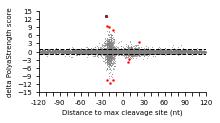

In [20]:
fig,ax = plt.subplots(1,1, figsize = (3,1.5))

ax.axhline(y = -thresh_delta, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.axhline(y = +thresh_delta, color = 'black', linestyle = 'dashed', linewidth = 1)

sns.scatterplot(data = ukbb_repr_xte, x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'gray', edgecolor = None, s = 1, alpha = 0.75, 
                rasterized = True, ax = ax)

sns.scatterplot(data = ukbb_repr_xte.loc[(ukbb_repr_xte['variantID'].isin(extreme_values)) & (np.abs(ukbb_repr_xte['deltaStrength']) >= thresh_delta)], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = None, s = 5, alpha = 1, 
                rasterized = True, ax = ax)

sns.scatterplot(data = ukbb_repr_xte.loc[(ukbb_repr_xte['variantID'].isin(paper_examples)) & (np.abs(ukbb_repr_xte['deltaStrength']) >= thresh_delta)], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = 'black', linewidth = 0.5, s = 7, alpha = 1, 
                rasterized = True, ax = ax)

ax.set_xlim(-120,120)
ax.set_xticks(np.arange(-120,121,10))
ax.set_xticklabels(['-120','','','-90','','','-60','','','-30','','','0','','','30','','','60','','','90','','','120'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Distance to max cleavage site (nt)")
ax.set_ylabel("delta PolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'ukbb.xte.change_strength_by_position.prob.repr.highlight.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


In [21]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','referenceClassprob','alternateClassprob','deltaClassification','referenceStrength','alternateStrength','deltaStrength']
ukbb_repr_xte.loc[(np.abs(ukbb_repr_xte['deltaStrength']) >= thresh_delta) & (ukbb_repr_xte['variantID'].isin(paper_examples)), preview_cols].sort_values('testSiteDistStranded')


,variantID,gene,affectedMotifs,testSiteDistStranded,referenceClassprob,alternateClassprob,deltaClassification,referenceStrength,alternateStrength,deltaStrength
98203,rs11548104,S100A14,created_AATAAA|AATAAA,-24,0.770492,0.999902,0.22941,-10.860615,2.156391,13.017006


In [22]:
ukbb_repr_xte.loc[(np.abs(ukbb_repr_xte['deltaStrength']) >= thresh_delta) & (ukbb_repr_xte['variantID'].isin(extreme_values)), preview_cols].sort_values('testSiteDistStranded')


,variantID,gene,affectedMotifs,testSiteDistStranded,referenceClassprob,alternateClassprob,deltaClassification,referenceStrength,alternateStrength,deltaStrength
1334808,rs139900407,RPUSD1,disrupted_AATAAA|AATAAA,-23,0.999296,0.665517,-0.333779,3.004667,-7.616665,-10.621332
1335484,rs3759937,UBE2I,created_ATTAAA|ATTAAA,-22,0.873768,0.993775,0.120006,-3.216384,6.034833,9.251217
1132234,rs78865465,IKZF4,created_AATAAA|AATAAA,-19,0.571645,0.999665,0.428020,-8.319536,0.816896,9.136433
889562,9:139942576_A_G,ENTPD2,disrupted_AATAAA|AATAAA,-18,0.999900,0.807037,-0.192863,8.091455,-3.668818,-11.760272
755674,rs10954213,IRF5,created_AATAAA|AATAAA,-14,0.621215,0.999979,0.378763,-6.491376,1.592399,8.083775
1423600,rs78378222,TP53,disrupted_AATAAA|AATAAA,-14,0.999963,0.815661,-0.184303,2.835746,-7.468203,-10.303949
1555434,19:2754703_AAGAC_A,SGTA,"modified_GT/CT-Rich|TCTGTC,GTCTTC,TCGTGT,GTCTG...",8,0.999056,0.998600,-0.000456,4.355872,0.662661,-3.693211
1302410,rs549823870,TPM1,"retained_T-Rich|TTGTTT,TGTTTT,TTTGTT,TTTTGT",9,0.483825,0.507219,0.023394,-7.871271,-10.678263,-2.806992
1335007,rs57884364,SSTR5,"modified_GT/CT-Rich|TCTGTC,GTCTGT,TGTCTG,TTGTC...",23,0.999980,0.999982,0.000002,-3.148207,0.175684,3.323890


#### Summarize the motifs affected by variants

In [23]:
ukbb_sum_dt = (
    assoc_xte.loc[assoc_xte['affectedMotifDirection'] != 'retained']
    [['variantID','affectedMotifDirection','affectedMotifFamily']]
    .drop_duplicates()
)

ukbb_sum = (ukbb_sum_dt
    .groupby(['affectedMotifFamily','affectedMotifDirection']).size()
    .reset_index().rename(columns = {0:'Count'})
)

ukbb_sum['Proportion'] = ukbb_sum['Count'] / ukbb_sum.groupby(['affectedMotifFamily'])['Count'].transform('sum')

print(ukbb_sum_dt.shape)
print(ukbb_sum_dt.variantID.nunique())
print(ukbb_sum['Count'].sum())


(892, 3)
890
892


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
notebook_setup.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  from sklearn.decomposition import PCA


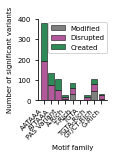

In [24]:
ordering = ['AATAAA','ATTAAA','PAS Variant','A-Rich','T-Rich','TGTA','TGTA-Rich','GT/CT-Rich','G-Rich']

modified_props  = ukbb_sum.loc[ukbb_sum['affectedMotifDirection'] == 'modified',  ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
disrupted_props = ukbb_sum.loc[ukbb_sum['affectedMotifDirection'] == 'disrupted', ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
created_props   = ukbb_sum.loc[ukbb_sum['affectedMotifDirection'] == 'created',   ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)

fig,ax = plt.subplots(1,1, figsize = (1.25,1.5))

plt.bar(ordering, modified_props, label = 'Modified', color = 'gray', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, disrupted_props, bottom = modified_props, label = 'Disrupted', color = '#B3589A', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, created_props, bottom = modified_props + disrupted_props, label = 'Created', color = 'seagreen', edgecolor = 'black', linewidth = 0.5)

ax.set_xticklabels(ordering, rotation = 45, ha = 'right', va = 'top')
ax.set_xlabel("Motif family")
ax.set_ylabel("Number of significant variants")

ax.set_ylim(0,400)
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'ukbb.xte.effect_by_family_by_direction.count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Examples of disease-related variants and gene


##########
S100A14

Associated conditions-	 AG
			GGT
			Plt
			TBil 

variantID                            rs11548104
chrom                                      chr1
position                              153587308
strand                                        -
reference                                     C
alternate                                     T
gene                                    S100A14
geneStrand                                    -
affectedMotif            created_AATAAA_S100A14
positionTest                          153587284
testSiteDistStranded                        -24
referenceFeature                  terminal_exon
referenceClassprob                     0.770492
alternateClassprob                     0.999902
deltaClassification                     0.22941
referenceStrength                      -10.8606
alternateStrength                       2.15639
deltaStrength                            13.017
referenceStrengthProb               0.000537521
alternateStrengt

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


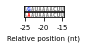

In [25]:
example_cols = ['variantID', 'chrom', 'position', 'strand', 'reference', 'alternate',
                'gene', 'geneStrand', 'affectedMotif', 'positionTest', 'testSiteDistStranded','referenceFeature',
                'referenceClassprob', 'alternateClassprob','deltaClassification',
                'referenceStrength', 'alternateStrength', 'deltaStrength',
                'referenceStrengthProb', 'alternateStrengthProb', 'deltaStrengthProb',
                'referenceICprob', 'alternateICprob', 'referenceISprob', 'alternateISprob',
                'readsExact', 'readsSlop', 'directionEffect', 'affectedMotifs', 'condition',
                'clinical_significance', 'codingEffect']

example_ids = ['rs11548104']
example_gene = ['S100A14']
example_range = [(120-25,120-15+1)]

for eid, egene, erange in zip(example_ids, example_gene, example_range):
    
    if (eid == ''):
        continue
    
    print(f"\n##########\n{egene}")
    print("\nAssociated conditions-\t", "\n\t\t\t".join(sorted(set(ukbb_filt_long.loc[(ukbb_filt_long['variantID'] == eid) & (~ukbb_filt_long['condition'].isin(['not_provided','not_specified','NA'])), 'condition'].tolist()))), "\n")
    print(ukbb_filt_long.loc[ukbb_filt_long['variantID'] == eid].iloc[0][example_cols])
    
    e_name = f'ukbb.{eid}.{egene}'
    e_data = ukbb_filt_long.loc[(ukbb_filt_long['variantID'] == eid) & (ukbb_filt_long['gene'] == egene)].iloc[0]

    genetics.plot_variant_logo(os.path.join(OUTDIR, f'variant_examples.ukbb.{e_name}.svg'),
                               e_data['referenceSequence'], e_data['alternateSequence'], 
                               erange, [120+e_data['testSiteDistStranded']])
    